<a href="https://colab.research.google.com/github/Otobi1/Back-to-Basics-A-Refresher-/blob/master/Back_to_Basics_Data_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Quality 

# - Overall, ML models consumes data and produces predicts 
# - the quality of predictions directly corresponds to the quality of the data you train the model with
# - in short GIGO (garbage in, garbage out)

# in this lesson, we will explore all the concepts with concrete code examples and some 
# ... synthesised data for model training

In [2]:
# Set up

import numpy as np
import random

In [3]:
SEED = 1234

In [4]:
# Set seed for reproducibility 

np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Full dataset
# - First, we'll train a model with the entire dataset, then we'll remove a subset of the data to see its effects on our model

import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [6]:
# Load data 

url = "https://raw.githubusercontent.com/GokuMohandas/madewithml/main/datasets/tumors.csv"
df = pd.read_csv(url, header = 0) # loading the dataset
df = df.sample(frac = 1).reset_index(drop = True) # Shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [8]:
# Define X and y

X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1000, 2)
y:  (1000,)


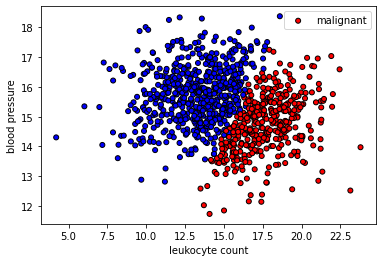

In [9]:
# Plot data

colours = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:,1], c = [colours[_y] for _y in y], s = 25, edgecolors = "k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc = "upper right")
plt.show()

In [10]:
# We want to choose features that have strong predictive signal for our task
# If you want to improve performance, you need to continuously do feature engineerng by collecting and adding new signals
# - You may get a feature that has a high correlation (orthogonal signal) with your existing features but it may still possess some unique signal to boost your predictive performance


,leukocyte_count,blood_pressure
leukocyte_count,1.000000,-0.162875
blood_pressure,-0.162875,1.000000


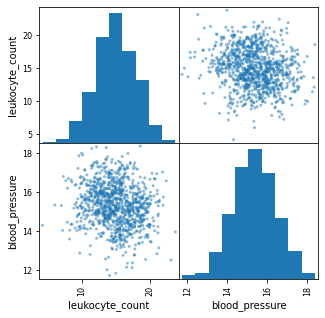

In [12]:
# Correlation matrix 

scatter_matrix(df, figsize = (5, 5));
df.corr()

In [13]:
# Split data 

import collections
from sklearn.model_selection import train_test_split

In [14]:
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [15]:
def train_val_test_split(X, y, train_size):
  """Split dataset into data splits."""
  X_train, X_, y_train, y_ = train_test_split(X, y, train_size = TRAIN_SIZE, stratify = y)
  X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size = 0.5, stratify = y_)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
# Create data splits 
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X = X, y = y, train_size = TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} -> {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] -> malignant


In [17]:
# Label encoding 

from sklearn.preprocessing import LabelEncoder

In [18]:
# Output vectorizer 

label_encoder = LabelEncoder()

In [19]:
# Fit on train data

label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")

classes: ['benign', 'malignant']


In [20]:
# Convert labels to tokens 

print(f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print (f"y_train[0]: {y_train[0]}")

y_train[0]: malignant
y_train[0]: 1


In [21]:
# Class weights 

counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


In [22]:
# Standardise data 

from sklearn.preprocessing import StandardScaler

In [23]:
# Standardise the data (mean = 0, std = 1) using the trainin data

X_scaler = StandardScaler().fit(X_train)

In [24]:
# Apply scaler on training and test data (dont standardise outputs for classification)

X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [25]:
# Check the outputs of the standardisation 

print (f"X_test[0]: Mean: {np.mean(X_test[:, 0], axis = 0):.1f}, std: {np.std(X_test[:, 0], axis = 0):.1f}")
print (f"X_test[0]: Mean: {np.mean(X_test[:, 1], axis = 0):.1f}, std: {np.std(X_test[:, 1], axis = 0):.1f}")

X_test[0]: Mean: -0.1, std: 1.0
X_test[0]: Mean: -0.1, std: 1.0


In [26]:
# Model 

import torch 
from torch import nn
import torch.nn.functional as F

In [27]:
# Set see for reproducibility 

torch.manual_seed(SEED)

In [28]:
INPUT_DIM = 2 # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = 2

In [29]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_classes):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, num_classes)

  def forward(self, x_in, apply_softmax = False):
    z = F.relu(self.fc1(x_in)) # ReLU activation function added 
    y_pred = self.fc2(z)
    if apply_softmax:
      y_pred = F.softmax(y_pred, dim = 1)
    return y_pred

In [30]:
# Initialise model 

model = MLP(input_dim = INPUT_DIM, hidden_dim = HIDDEN_DIM, num_classes = NUM_CLASSES)

print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>


In [31]:
# Training 

from torch.optim import Adam

In [32]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BATCH_SIZE = 32

In [33]:
# Define loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight = class_weights_tensor)

In [34]:
# Accuracy

def accuracy_fn(y_pred, y_true):
  n_correct = torch.eq(y_pred, y_true).sum().item()
  accuracy = (n_correct / len(y_pred)) * 100
  return accuracy

In [35]:
# Optimiser

optimiser = Adam(model.parameters(), lr = LEARNING_RATE)

In [36]:
# Convert data to tensors 

X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [38]:
# the training 

for epoch in range (NUM_EPOCHS * 10):
  
  # Forward pass 
  y_pred = model(X_train)

  # Loss
  loss = loss_fn(y_pred, y_train)

  # Zero all gradients 
  optimiser.zero_grad()

  # Backward pass 
  loss.backward()

  # Update weights
  optimiser.step()

  if epoch%10 == 0:
    predictions = y_pred.max(dim = 1)[1] # class 
    accuracy = accuracy_fn(y_pred = predictions, y_true = y_train)
    print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 0.68, accuracy: 55.1
Epoch: 10 | loss: 0.53, accuracy: 93.6
Epoch: 20 | loss: 0.42, accuracy: 97.6
Epoch: 30 | loss: 0.35, accuracy: 97.4
Epoch: 40 | loss: 0.29, accuracy: 97.4


In [39]:
# Evaluation 

import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [40]:
def get_performance(y_true, y_pred, classes):
  """Per class performance metrics."""
  # Get metrics
  performance = {"overall": {}, "class": {}}
  metrics = precision_recall_fscore_support(y_true, y_pred)

  # Overall performance 
  performance["overall"]["precision"] = np.mean(metrics[0])
  performance["overall"]["recall"] = np.mean(metrics[1])
  performance["overall"]["f1"] = np.mean(metrics[2])
  performance["overall"]["precision"] = np.float64(np.sum(metrics[3]))

  # Per class performance 
  for i in range (len(classes)):
    performance["class"][classes[i]] = {
        "precision": metrics[0][i], 
        "recall": metrics[1][i], 
        "f1": metrics[2][i], 
        "num_samples": np.float64(metrics[3][i])
    }
  return performance


In [41]:
# Predictions 

y_prob = model(X_test, apply_softmax = True)
y_pred = y_prob.max(dim = 1)[1]

In [42]:
# Performance report 

performance = get_performance(y_true = y_test, y_pred = y_pred, classes = classes)
print (json.dumps(performance, indent = 2))

{
  "overall": {
    "precision": 150.0,
    "recall": 0.9632683658170915,
    "f1": 0.9647473560517039
  },
  "class": {
    "benign": {
      "precision": 0.9649122807017544,
      "recall": 0.9482758620689655,
      "f1": 0.9565217391304347,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.967741935483871,
      "recall": 0.9782608695652174,
      "f1": 0.972972972972973,
      "num_samples": 92.0
    }
  }
}


In [43]:
# Inference 
# - We'll plot a point we know belongs to a malignant tumor class
# - Our well trained model would accurately predit it is indeed malignant 



In [46]:
def plot_multiclass_decision_boundary(model, X, y):
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
  cmap = plt.cm.Spectral

  X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
  y_pred = model(X_test, apply_softmax = True)
  _, y_pred = y_pred.max(dim = 1)
  y_pred = y_pred.reshape(xx.shape)
  plt.contourf(xx, yy, y_pred, cmap = plt.cm.Spectral, alpha = 0.8)
  plt.scatter(X[:, 0], X[:, 1], c = y, s = 40, cmap = plt.cm.RdYlGn_r)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

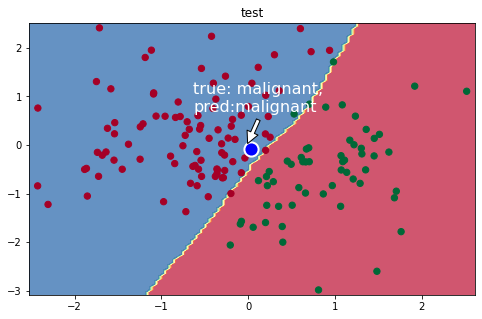

In [48]:
# Visualise the decision boundary 

plt.figure(figsize = (8, 5))
plt.title("test")
plot_multiclass_decision_boundary(model = model, X = X_test, y = y_test)

# Sample point near the decision boundary 
mean_leukocyte_count, mean_blood_pressure = X_scaler.transform(
    [[np.mean(df.leukocyte_count), np.mean(df.blood_pressure)]])[0]
plt.scatter(mean_leukocyte_count + 0.05, mean_blood_pressure - 0.05, s = 200, 
            c = "b", edgecolor = "w", linewidth = 2)

# Annotate
plt.annotate("true: malignant, \npred:malignant",#
             color = "white", 
             xy = (mean_leukocyte_count, mean_blood_pressure), 
             xytext = (0.4, 0.65), 
             textcoords = "figure fraction", 
             fontsize = 16, 
             arrowprops = dict(facecolor = "white", shrink = 0.1))
plt.show()